Here we look at Medical Transcriptions dataset from Kaggle
https://www.kaggle.com/tboyle10/medicaltranscriptions

This data was scraped from mtsamples.com

Inspiration
Can you correctly classify the medical specialties based on the transcription text?


Let us import all the necessary libraries

In [1]:

import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE

A method to get unique words(vocabulary) and sentence count in a list of text 

In [4]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count
    

Lets do some exploratory analysis of data

In [3]:
clinical_text_df = pd.read_csv('C:\\MedicalClassification\\mtsamples.csv')

print(clinical_text_df.columns)
clinical_text_df.head(5)

Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [5]:

clinical_text_df = clinical_text_df[clinical_text_df['transcription'].notna()]
sent_count,word_count= get_sentence_word_count(clinical_text_df['transcription'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))



data_categories  = clinical_text_df.groupby(clinical_text_df['medical_specialty'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')





Number of sentences in transcriptions column: 140214
Number of unique words in transcriptions column: 35822
===========Original Categories =======================
Cat:1  Allergy / Immunology : 7
Cat:2  Autopsy : 8
Cat:3  Bariatrics : 18
Cat:4  Cardiovascular / Pulmonary : 371
Cat:5  Chiropractic : 14
Cat:6  Consult - History and Phy. : 516
Cat:7  Cosmetic / Plastic Surgery : 27
Cat:8  Dentistry : 27
Cat:9  Dermatology : 29
Cat:10  Diets and Nutritions : 10
Cat:11  Discharge Summary : 108
Cat:12  ENT - Otolaryngology : 96
Cat:13  Emergency Room Reports : 75
Cat:14  Endocrinology : 19
Cat:15  Gastroenterology : 224
Cat:16  General Medicine : 259
Cat:17  Hematology - Oncology : 90
Cat:18  Hospice - Palliative Care : 6
Cat:19  IME-QME-Work Comp etc. : 16
Cat:20  Lab Medicine - Pathology : 8
Cat:21  Letters : 23
Cat:22  Nephrology : 81
Cat:23  Neurology : 223
Cat:24  Neurosurgery : 94
Cat:25  Obstetrics / Gynecology : 155
Cat:26  Office Notes : 50
Cat:27  Ophthalmology : 83
Cat:28  Orthoped

In [6]:
filtered_data_categories = data_categories.filter(lambda x:x.shape[0] > 50)
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
i=1
print('============Reduced Categories ======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============ Reduced Categories ======================')


============Reduced Categories ======================
Cat:1  Cardiovascular / Pulmonary : 371
Cat:2  Consult - History and Phy. : 516
Cat:3  Discharge Summary : 108
Cat:4  ENT - Otolaryngology : 96
Cat:5  Emergency Room Reports : 75
Cat:6  Gastroenterology : 224
Cat:7  General Medicine : 259
Cat:8  Hematology - Oncology : 90
Cat:9  Nephrology : 81
Cat:10  Neurology : 223
Cat:11  Neurosurgery : 94
Cat:12  Obstetrics / Gynecology : 155
Cat:13  Ophthalmology : 83
Cat:14  Orthopedic : 355
Cat:15  Pain Management : 61
Cat:16  Pediatrics - Neonatal : 70
Cat:17  Psychiatry / Psychology : 53
Cat:18  Radiology : 273
Cat:19  SOAP / Chart / Progress Notes : 166
Cat:20  Surgery : 1088
Cat:21  Urology : 156
============ Reduced Categories ======================


In [7]:
print('============Reduced Categories Transcription example======================')
i=1
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    dataList = dataCategory['transcription'].tolist()
    print('====================================================')
    print('Sample Transcription:'+str(dataList[10]))
    print('====================================================')
    i = i+1

print('============ Reduced Categories Transcription example======================')

============Reduced Categories Transcription example======================
Cat:1  Cardiovascular / Pulmonary : 371
Sample Transcription:PREOPERATIVE DIAGNOSIS: , Need for intravenous access.,POSTOPERATIVE DIAGNOSIS: , Need for intravenous access.,PROCEDURE PERFORMED:  ,Insertion of a right femoral triple lumen catheter.,ANESTHESIA: , Includes 4 cc of 1% lidocaine locally.,ESTIMATED BLOOD LOSS: , Minimum.,INDICATIONS:,  The patient is an 86-year-old Caucasian female who presented to ABCD General Hospital secondary to drainage of an old percutaneous endoscopic gastrostomy site.  The patient is also ventilator-dependent, respiratory failure with tracheostomy in place and dependent on parenteral nutrition secondary to dysphagia and also has history of protein-calorie malnutrition and the patient needs to receive total parenteral nutrition and therefore needs central venous access.,PROCEDURE:,  The patient's legal guardian was talked to.  All questions were answered and consent was obtained

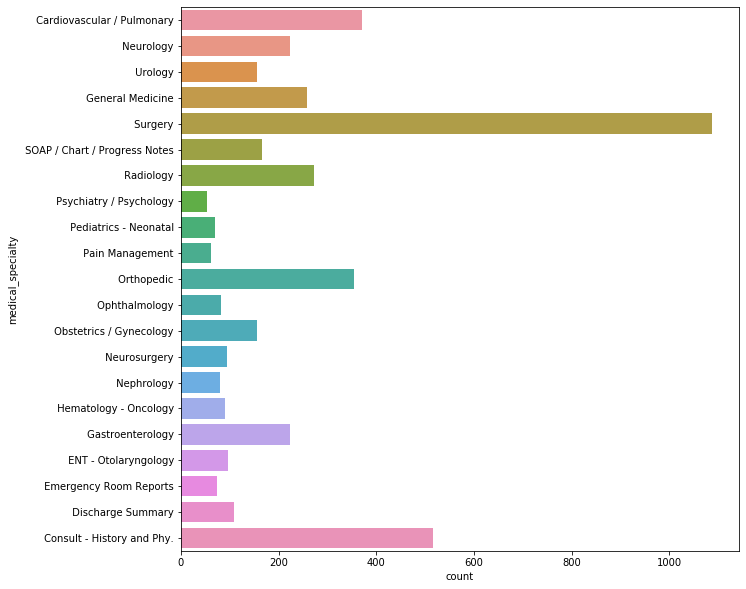

In [29]:
plt.figure(figsize=(10,10))
sns.countplot(y='medical_specialty', data = filtered_data_categories )
plt.show()

We are interested only in the 'transcription' and 'medical_specialty' columns in the dataset

In [19]:
data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape


(4597, 2)

In [8]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])


Sample Transcription 1:CC:, Confusion and slurred speech.,HX , (primarily obtained from boyfriend): This 31 y/o RHF experienced a "flu-like illness 6-8 weeks prior to presentation. 3-4 weeks prior to presentation, she was found "passed out" in bed, and when awoken appeared confused, and lethargic. She apparently recovered within 24 hours. For two weeks prior to presentation she demonstrated emotional lability, uncharacteristic of her ( outbursts of anger and inappropriate laughter). She left a stove on.,She began slurring her speech 2 days prior to admission. On the day of presentation she developed right facial weakness and began stumbling to the right. She denied any associated headache, nausea, vomiting, fever, chills, neck stiffness or visual change. There was no history of illicit drug/ETOH use or head trauma.,PMH:, Migraine Headache.,FHX: , Unremarkable.,SHX: ,Divorced. Lives with boyfriend. 3 children alive and well. Denied tobacco/illicit drug use. Rarely consumes ETOH.,ROS:, I

In [ ]:
Lets define soome methods for cleaning the data

In [24]:
def clean_text(text ): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    #BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    #text2 = BAD_SYMBOLS_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist) 


Lets clean the data

In [25]:

data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)

In [26]:
print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:cc confusion and slurred speech hx primarily obtained from boyfriend this yo rhf experienced a flulike illness week prior to presentation week prior to presentation she wa found passed out in bed and when awoken appeared confused and lethargic exam revealed the hemiparesis and in addition she wa found to have significant neck lymphadenopathy obgyn exam including cervical biopsy and abdominalpelvic ct scanning revealed stage iv squamous cell cancer of the cervix

Sample Transcription 2:admitting diagnosis hematuria he is to follow up with dr g of urology in the next week by phone in regard to the patient s mri and plan for a laparoscopic partial renal resection biopsy this is scheduled for the week after discharge potentially by dr g and the patient will discus the exact time later this week

Sample Transcription 3:preoperative diagnosis phimosis and adhesion postoperative diagnosis phimosis and adhesion procedure performed circumcision and release of ventral chor

Lets us peform feature extraction using TfidfVectorizer to generate tf-idf features.
For more on tf-idf check here: https://en.wikipedia.org/wiki/Tf%E2%80%93idf
In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.[1] It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

In [27]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75, use_idf=True, smooth_idf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['abc', 'abcd', 'abdomen', 'abdomen pelvis', 'abdominal', 'abdominal pain', 'abnormal', 'abnormality', 'abscess', 'activity', 'acute', 'additional', 'adequate', 'administered', 'admission', 'admission diagnosis', 'admitted', 'admitting', 'admitting diagnosis', 'africanamerican', 'age', 'ago', 'airway', 'alcohol', 'allergy', 'alternative', 'anemia', 'anesthesia', 'anesthesia general', 'anesthesia general endotracheal', 'anesthesia local', 'anesthesia wa', 'anesthetic', 'angiography', 'ankle', 'anterior', 'anterior cervical', 'anterior cervical discectomy', 'antibiotic', 'aortic', 'ap', 'apnea', 'apparent', 'apparently', 'appear', 'appeared', 'appears', 'appendicitis', 'applied', 'applied patient', 'appointment', 'appropriate', 'approximately', 'area', 'arm', 'artery', 'artery disease', 'arthritis', 'asked', 'aspect', 'aspiration', 'assessment', 'associated', 'atrial', 'atrial fibrillation', 'awakened', 'axial', 'axis', 'baby', 'base', 'began', 'benefit', 'better', 'bid', 'bilateral', 'b

Lets visualize the tf-idf features using t-sne plot. For more on t-sne check here: https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
T-distributed Stochastic Neighbor Embedding (t-SNE) is a machine learning algorithm for visualization developed by Laurens van der Maaten and Geoffrey Hinton.[1] It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.


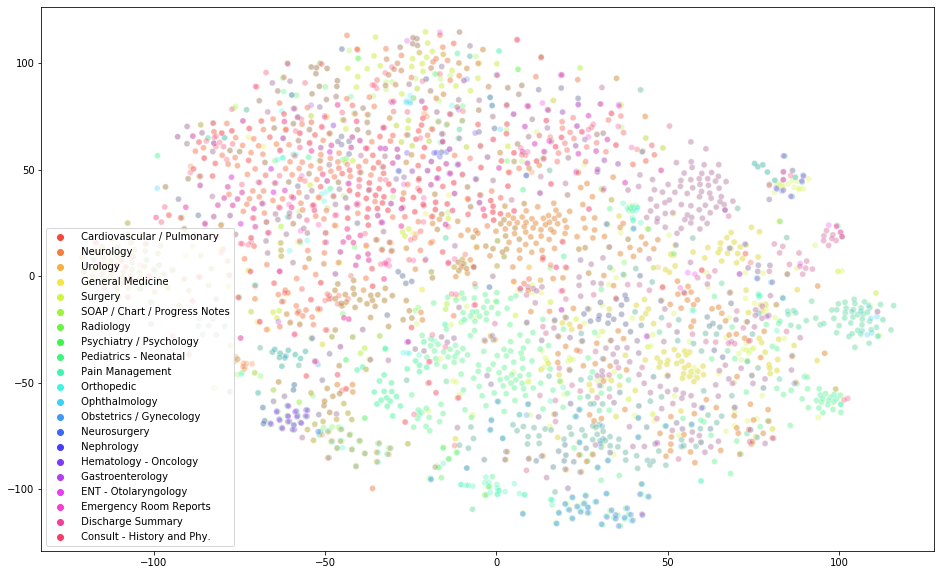

In [30]:
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(16,10))
palette = sns.hls_palette(21, l=.6, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()



Let us do PCA to reduce dimensionality of features.
https://en.wikipedia.org/wiki/Principal_component_analysis
PCA is defined as an orthogonal linear transformation that transforms the data to a new coordinate system such that the greatest variance by some scalar projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on

In [31]:
gc.collect()
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)   


In [32]:
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(3447, 614)
Test_Set_Size:(1150, 614)


Let us use Logisitic Regression to learn on training data and predict on test data
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [33]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

Let us visualize the confusion matrix and the classification results

In [34]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels)

C:\Users\Rithesh\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass labels=[' Cardiovascular / Pulmonary' ' Neurology' ' Urology' ' General Medicine'
 ' Surgery' ' SOAP / Chart / Progress Notes' ' Radiology'
 ' Psychiatry / Psychology' ' Pediatrics - Neonatal' ' Pain Management'
 ' Orthopedic' ' Ophthalmology' ' Obstetrics / Gynecology' ' Neurosurgery'
 ' Nephrology' ' Hematology - Oncology' ' Gastroenterology'
 ' ENT - Otolaryngology' ' Emergency Room Reports' ' Discharge Summary'
 ' Consult - History and Phy.'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


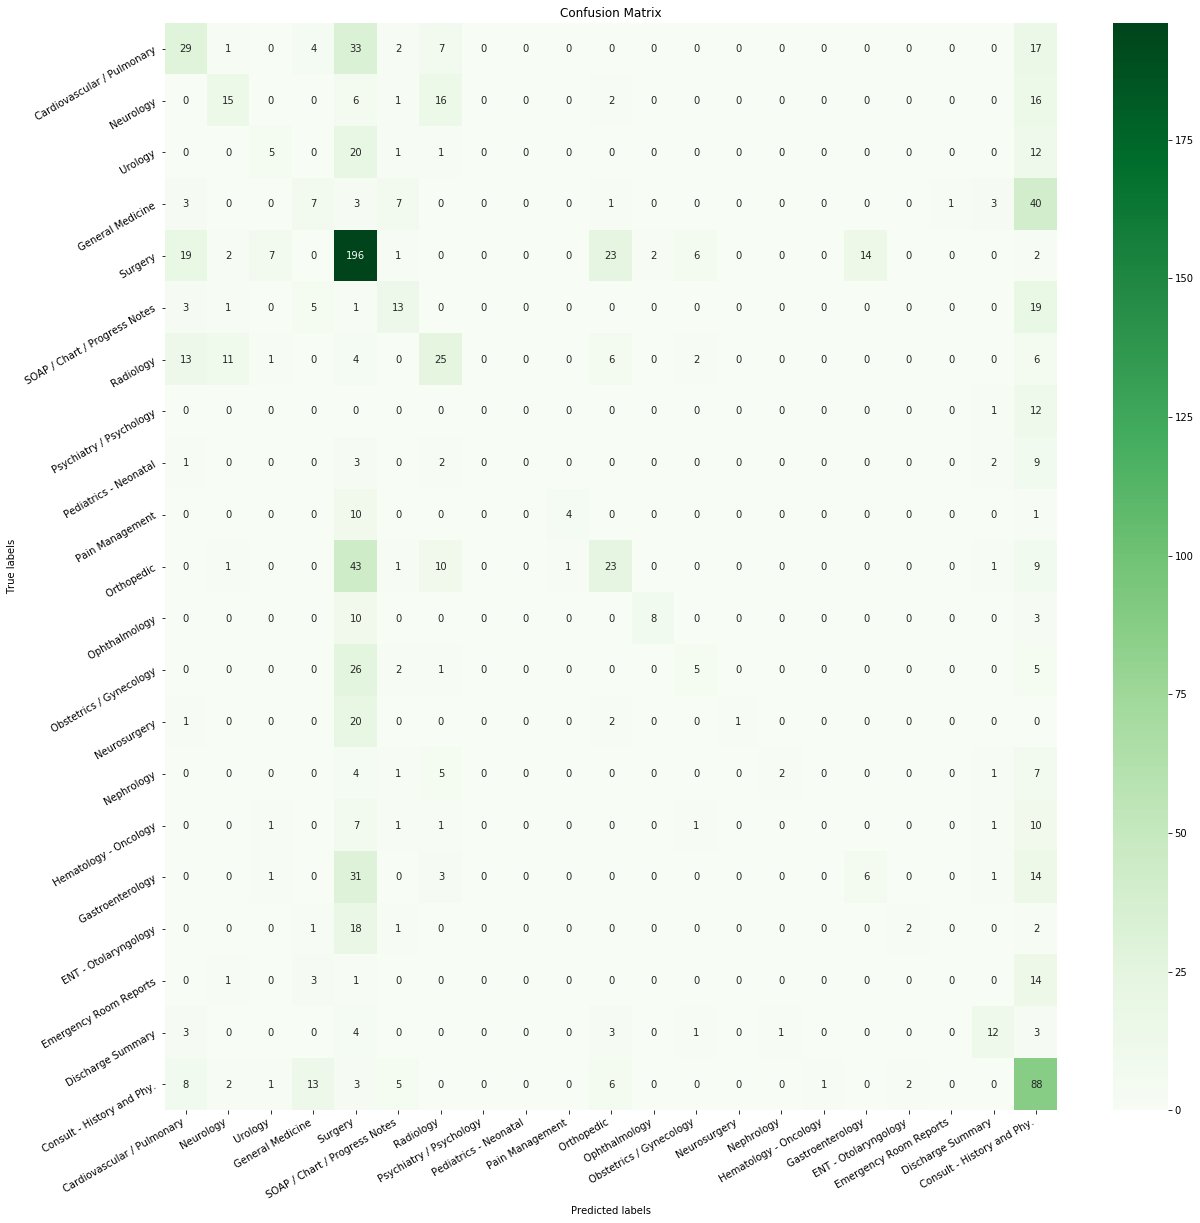

In [35]:

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

In [18]:
print(classification_report(y_test,y_test_pred,labels=category_list))

                                precision    recall  f1-score   support

    Cardiovascular / Pulmonary       0.40      0.39      0.40        93
                     Neurology       0.40      0.41      0.41        56
                       Urology       0.22      0.13      0.16        39
              General Medicine       0.20      0.15      0.17        65
                       Surgery       0.47      0.65      0.55       272
 SOAP / Chart / Progress Notes       0.32      0.29      0.30        42
                     Radiology       0.35      0.32      0.34        68
       Psychiatry / Psychology       0.00      0.00      0.00        13
         Pediatrics - Neonatal       0.00      0.00      0.00        17
               Pain Management       0.46      0.40      0.43        15
                    Orthopedic       0.40      0.36      0.38        89
                 Ophthalmology       0.47      0.33      0.39        21
                  Office Notes       0.00      0.00      0.00  

C:\Users\Rithesh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Let us apply some domain knowledge and see if we can improve the results

In [48]:
filtered_data_categories['medical_specialty'] =filtered_data_categories['medical_specialty'].apply(lambda x:str.strip(x))
mask = filtered_data_categories['medical_specialty'] == 'Surgery'
filtered_data_categories = filtered_data_categories[~mask]
final_data_categories = filtered_data_categories.groupby(filtered_data_categories['medical_specialty'])
mask = filtered_data_categories['medical_specialty'] == 'SOAP / Chart / Progress Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Office Notes'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Consult - History and Phy.'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Emergency Room Reports'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'Discharge Summary'
filtered_data_categories = filtered_data_categories[~mask]

'''
mask = filtered_data_categories['medical_specialty'] == 'Pediatrics - Neonatal'
filtered_data_categories = filtered_data_categories[~mask]
'''
mask = filtered_data_categories['medical_specialty'] == 'Pain Management'
filtered_data_categories = filtered_data_categories[~mask]
mask = filtered_data_categories['medical_specialty'] == 'General Medicine'
filtered_data_categories = filtered_data_categories[~mask]


mask = filtered_data_categories['medical_specialty'] == 'Neurosurgery'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Neurology'
mask = filtered_data_categories['medical_specialty'] == 'Nephrology'
filtered_data_categories.loc[mask, 'medical_specialty'] = 'Urology'


i=1
print('============Reduced Categories======================')
for catName,dataCategory in final_data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1

print('============Reduced Categories======================')


data = filtered_data_categories[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.shape

============Reduced Categories======================
Cat:1 Cardiovascular / Pulmonary : 371
Cat:2 ENT - Otolaryngology : 96
Cat:3 Gastroenterology : 224
Cat:4 Hematology - Oncology : 90
Cat:5 Neurology : 317
Cat:6 Obstetrics / Gynecology : 155
Cat:7 Ophthalmology : 83
Cat:8 Orthopedic : 355
Cat:9 Pediatrics - Neonatal : 70
Cat:10 Psychiatry / Psychology : 53
Cat:11 Radiology : 273
Cat:12 Urology : 237
============Reduced Categories======================


(2324, 2)

Let us use sciscpacy models to detect medical entities in our text
scispaCy is a Python package containing spaCy models for processing biomedical, scientific or clinical text.
For more on scispacy check here:https://allenai.github.io/scispacy/

In [49]:

nlp = spacy.load("en_ner_bionlp13cg_md")

In [50]:
def process_Text( text):
    wordlist=[]
    doc = nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist)     

In [51]:
data['transcription'] = data['transcription'].apply(process_Text)
data['transcription'] = data['transcription'].apply(lemmatize_text)
data['transcription'] = data['transcription'].apply(clean_text)


In [52]:

print('Sample Transcription 1:'+data.iloc[5]['transcription']+'\n')
print('Sample Transcription 2:'+data.iloc[125]['transcription']+'\n')
print('Sample Transcription 3:'+data.iloc[1000]['transcription'])

Sample Transcription 1:boyfriend bed her right facial right child bp name  cn only  motor rue pronator extremity flexor bilaterally  general cbc gs ua pt ptt esr crp ekg hct hypodensities right putamen left caudate subcortical right basal ganglion edema left caudate nucleus arterial fibromuscular dysplasia hiv ana anticardiolipin antibody cardiac enzyme b cholesterol cerebral vascular caliber her  right exam neck lymphadenopathy cervical biopsy cervix cervical cancer

Sample Transcription 2:performed   ureteral stent right renal pelvis urine right upper pole patient right kidney patient supine dorsal lithotomy ureter patient bladder patient prostate bladder patient bladder right ureteral orifice right ureteral right ureteral catheter bladder bladder proximal ureter upj ureteral dilating sheath amplatz sheath ureter upj ureter upj upj dilator right ureter upper papillary  biopsy forceps biopsy papillary mass bladder ureteral right renal right renal pelvis bladder bladder patient patient

In [53]:

vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,3), max_df=0.75,min_df=5, use_idf=True, smooth_idf=True,sublinear_tf=True, max_features=1000)
tfIdfMat  = vectorizer.fit_transform(data['transcription'].tolist() )
feature_names = sorted(vectorizer.get_feature_names())
print(feature_names)

['abc', 'abcd', 'abdomen', 'abdomen abdomen', 'abdomen bowel', 'abdomen patient', 'abdominal', 'abdominal cavity', 'abdominal patient', 'abdominal wall', 'ace', 'acetabulum', 'achilles', 'achilles tendon', 'acid', 'adenocarcinoma', 'adenoid', 'adenoma', 'adenopathy', 'adenosine', 'admission', 'adrenal', 'adrenal gland', 'airway', 'albumin', 'albuterol', 'alcohol', 'alcohol patient', 'allergies', 'allograft', 'alt', 'amniotic', 'anesthesia', 'anesthesia patient', 'annular', 'anterior', 'anterior abdominal', 'anterior border', 'anterior border sternocleidomastoid', 'anterior cervical', 'anterior cruciate', 'anterolateral', 'antrum', 'aorta', 'aorta aorta', 'aortic', 'aortic arch', 'aortic valve', 'ap', 'ap lateral', 'appendix', 'arch', 'area', 'arm', 'arterial', 'artery', 'artery carotid', 'artery carotid artery', 'artery coronary', 'artery coronary artery', 'artery left', 'artery patient', 'artery proximal', 'artery pulmonary', 'artery pulmonary artery', 'artery right', 'artery vessel',

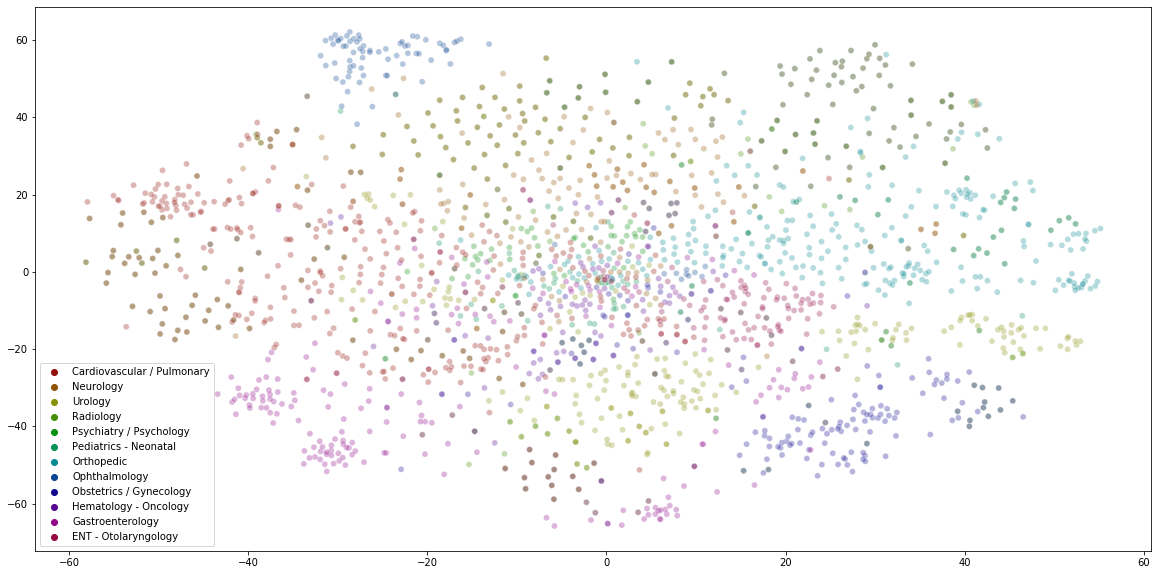

In [54]:
import gc
gc.collect()
tfIdfMatrix = tfIdfMat.todense()
labels = data['medical_specialty'].tolist()
tsne_results = TSNE(n_components=2,init='random',random_state=0, perplexity=40).fit_transform(tfIdfMatrix)
plt.figure(figsize=(20,10))
palette = sns.hls_palette(12, l=.3, s=.9)
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=labels,
    palette= palette,
    legend="full",
    alpha=0.3
)
plt.show()



In [55]:
pca = PCA(n_components=0.95)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels = data['medical_specialty'].tolist()
category_list = data.medical_specialty.unique()

Let us create train and test sets.Let us use logistic regression for developing a classification model and then visualize the results

In [56]:
X_train, X_test, y_train, y_test = train_test_split(tfIdfMat_reduced, labels, stratify=labels,random_state=1)   
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1743, 582)
Test_Set_Size:(581, 582)


In [57]:
#clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)


C:\Users\Rithesh\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass labels=['Cardiovascular / Pulmonary' 'Neurology' 'Urology' 'Radiology'
 'Psychiatry / Psychology' 'Pediatrics - Neonatal' 'Orthopedic'
 'Ophthalmology' 'Obstetrics / Gynecology' 'Hematology - Oncology'
 'Gastroenterology' 'ENT - Otolaryngology'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


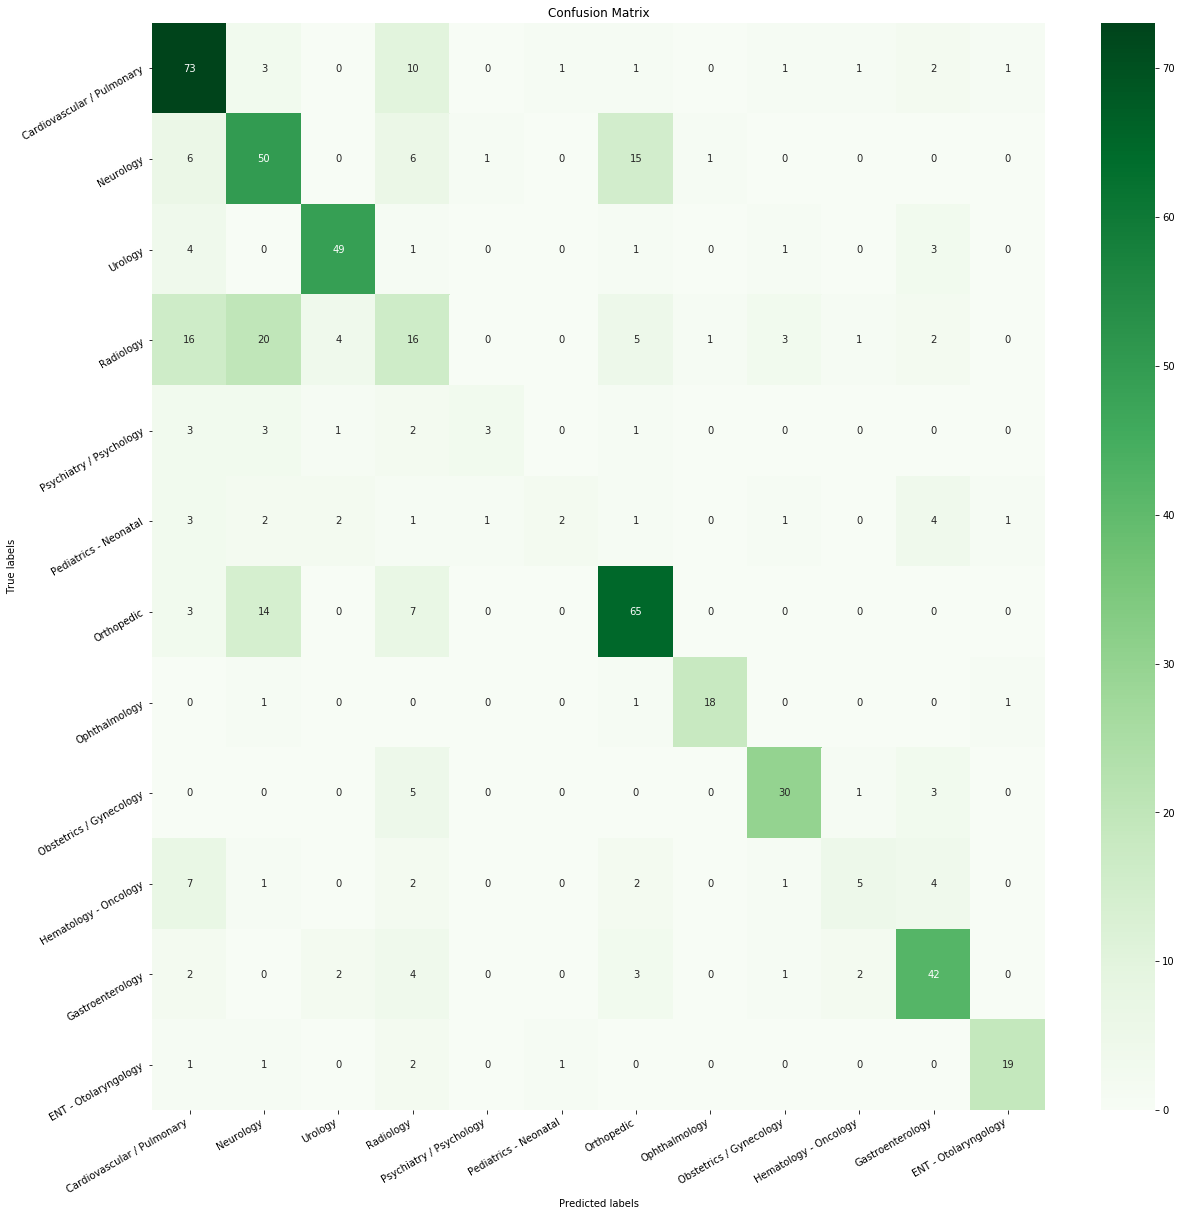

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.62      0.78      0.69        93
                 Neurology       0.53      0.63      0.57        79
                   Urology       0.84      0.83      0.84        59
                 Radiology       0.29      0.24      0.26        68
   Psychiatry / Psychology       0.60      0.23      0.33        13
     Pediatrics - Neonatal       0.50      0.11      0.18        18
                Orthopedic       0.68      0.73      0.71        89
             Ophthalmology       0.90      0.86      0.88        21
   Obstetrics / Gynecology       0.79      0.77      0.78        39
     Hematology - Oncology       0.50      0.23      0.31        22
          Gastroenterology       0.70      0.75      0.72        56
      ENT - Otolaryngology       0.86      0.79      0.83        24

                  accuracy                           0.64       581
                 macro avg       0.65      0.5

In [58]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))


Since some classes are in minority we can use SMOTE(Synthetic Minority Over-sampling Technique
) to generate more sample form minority class to solve the data imbalance problem. For more on SMOTE check here:https://arxiv.org/pdf/1106.1813.pdf. Let us generate new dataset using SMOTE and then perform classification on them


In [61]:
smote_over_sample = SMOTE(sampling_strategy='minority')
labels = data['medical_specialty'].tolist()
X, y = smote_over_sample.fit_resample(tfIdfMat_reduced, labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=1)   
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

Train_Set_Size:(1981, 582)
Test_Set_Size:(661, 582)


In [62]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

Let us visualize the data

C:\Users\Rithesh\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass labels=['Cardiovascular / Pulmonary' 'Neurology' 'Urology' 'Radiology'
 'Psychiatry / Psychology' 'Pediatrics - Neonatal' 'Orthopedic'
 'Ophthalmology' 'Obstetrics / Gynecology' 'Hematology - Oncology'
 'Gastroenterology' 'ENT - Otolaryngology'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


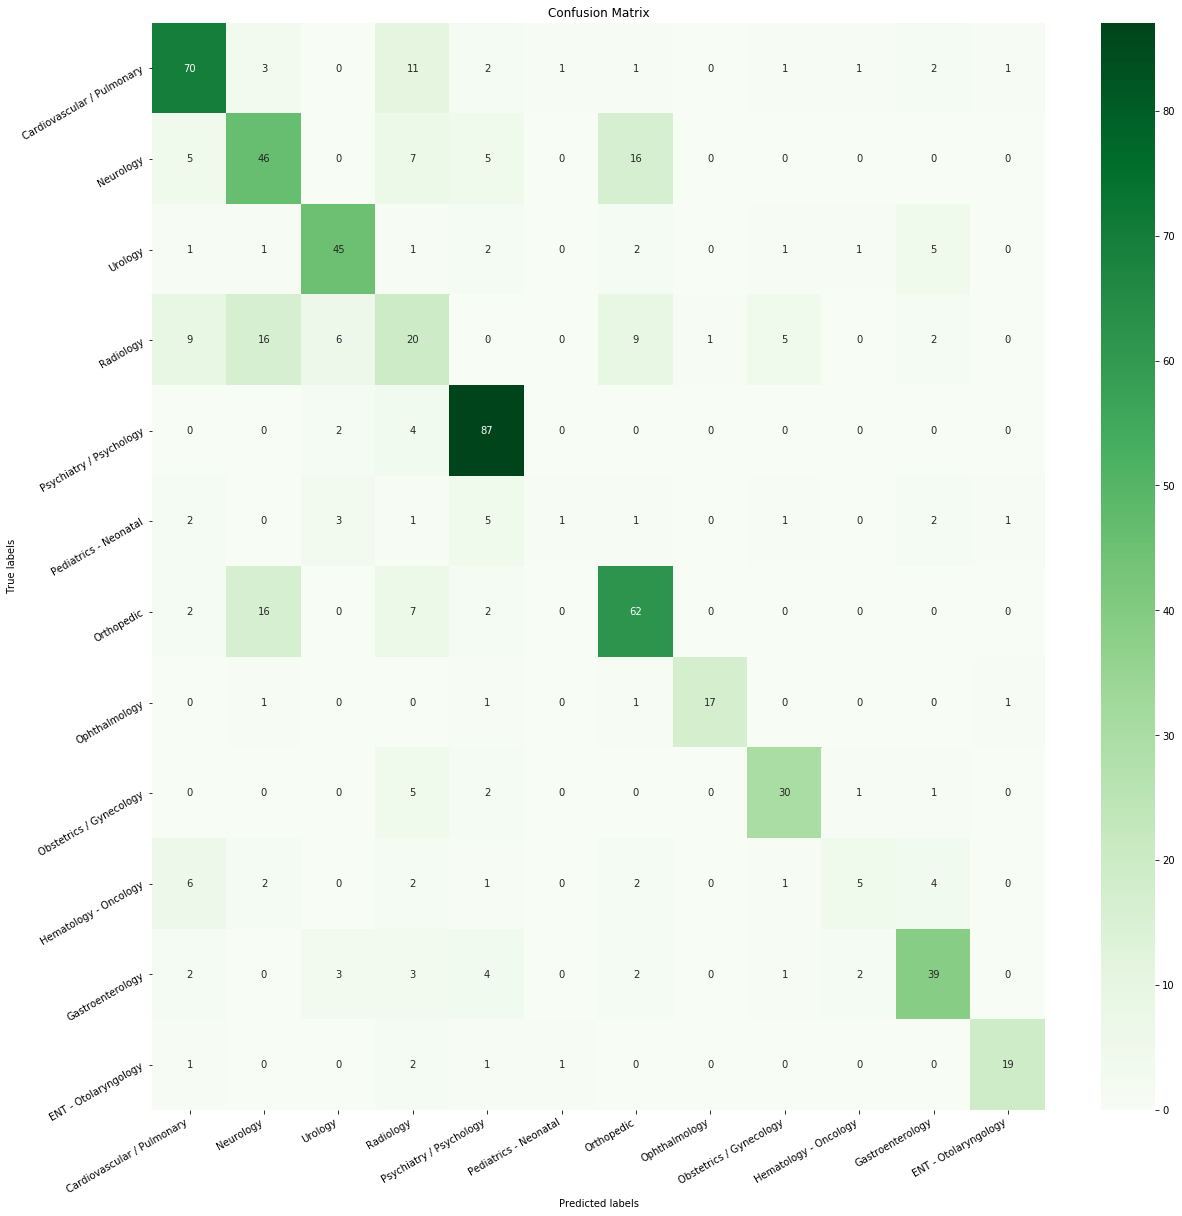

                            precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.71      0.75      0.73        93
                 Neurology       0.54      0.58      0.56        79
                   Urology       0.76      0.76      0.76        59
                 Radiology       0.32      0.29      0.31        68
   Psychiatry / Psychology       0.78      0.94      0.85        93
     Pediatrics - Neonatal       0.33      0.06      0.10        17
                Orthopedic       0.65      0.70      0.67        89
             Ophthalmology       0.94      0.81      0.87        21
   Obstetrics / Gynecology       0.75      0.77      0.76        39
     Hematology - Oncology       0.50      0.22      0.30        23
          Gastroenterology       0.71      0.70      0.70        56
      ENT - Otolaryngology       0.86      0.79      0.83        24

                  accuracy                           0.67       661
                 macro avg       0.65      0.6

In [63]:
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greens",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

In [52]:
mask = filtered_data_categories['medical_specialty'] == 'Radiology'
radiologyData = filtered_data_categories[mask]
print(radiologyData['transcription'].tolist()[1])

EXAM: , Two views of the soft tissues of the neck.,HISTORY:,  Patient has swelling of the left side of his neck.,TECHNIQUE:,  Frontal and lateral views of the soft tissues of the neck were evaluated. There were no soft tissues of the neck radiographs for comparison. However, there was an ultrasound of the neck performed on the same day.,FINDINGS: , Frontal and lateral views of the soft tissues of the neck were evaluated and reveal there is an asymmetry seen to the left-sided soft tissues of the patient's neck which appear somewhat enlarged when compared to patient's right side. However the trachea appears to be normal caliber and contour.  Lateral views show a patent airway. The adenoids and tonsils appear normal caliber without evidence of hypertrophy. Airway appears patent. Osseous structures appear grossly normal.,IMPRESSION:,1. Patent airway. No evidence of any soft tissue swelling involving the patient's adenoids/tonsils, epiglottis or aryepiglottic folds. No evidence of any preve

In [68]:
mask = clinical_text_df['medical_specialty'] ==  ' Pediatrics - Neonatal'
pediaData = clinical_text_df[mask]
print(pediaData ['transcription'].tolist()[1])

SUBJECTIVE:,  Patient presents with Mom and Dad for her 5-year 3-month well-child check.  Family has not concerns stating patient has been doing well overall since last visit.  Taking in a well-balanced diet consisting of milk and dairy products, fruits, vegetables, proteins and grains with minimal junk food and snack food.  No behavioral concerns.  Gets along well with peers as well as adults.  Is excited to start kindergarten this upcoming school year.  Does attend daycare.  Normal voiding and stooling pattern.  No concerns with hearing or vision.  Sees the dentist regularly.  Growth and development:  Denver II normal passing all developmental milestones per age in areas of fine motor, gross motor, personal and social interaction and speech and language development.  See Denver II form in the chart.,ALLERGIES:,  None.,MEDICATIONS: , None.,FAMILY SOCIAL HISTORY:,  Unchanged since last checkup.  Lives at home with mother, father and sibling.  No smoking in the home.,REVIEW OF SYSTEMS:,

In [67]:

mask = clinical_text_df['medical_specialty'] ==  ' Hematology - Oncology'
oncoData = clinical_text_df[mask]
print(oncoData ['transcription'].tolist()[1])

CHIEF COMPLAINT:,  Essential thrombocytosis.,HISTORY OF PRESENT ILLNESS: , This is an extremely pleasant 64-year-old gentleman who I am following for essential thrombocytosis.  He was first diagnosed when he first saw a hematologist on 07/09/07.  At that time, his platelet count was 1,240,000.  He was initially started on Hydrea 1000 mg q.d.  On 07/11/07, he underwent a bone marrow biopsy, which showed essential thrombocytosis.  He was positive for the JAK-2 mutation.  On 11/06/07, his platelets were noted to be 766,000.  His current Hydrea dose is now 1500 mg on Mondays and Fridays and 1000 mg on all other days.  He moved to ABCD in December 2009 in an attempt to improve his wife's rheumatoid arthritis.,Overall, he is doing well.  He has a good energy level, and his ECOG performance status is 0.  He denies any fevers, chills, or night sweats.  No lymphadenopathy.  No nausea or vomiting.  No change in bowel or bladder habits.,CURRENT MEDICATIONS: , Hydrea 1500 mg on Mondays and Fridays